## CMM536 Coursework
### Student: Famous Salami
### Number: 2213091

In [21]:
!pip install opencv-python
!pip install matplotlib
!pip install sklearn
!pip install scipy
!pip install keras
!pip install tensorflow
!pip install Image
!pip install Pillow
!pip --upgrade tensorflow >= 2.2


Usage:   
  pip <command> [options]

no such option: --upgrade


### Libraries

In [1]:
import os
import cv2
import numpy as npy
import matplotlib.pyplot as plt
from PIL import ImageDraw, Image
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

npy.random.seed(456) # for reproducibility and consistency

In [2]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix, \
roc_curve, auc, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import np_utils
from keras import backend as BACK_END

In [4]:
import tensorflow as tsf
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

### Declarations

In [5]:
#Defining an SVM Model
svm_model = SVC(kernel='linear')

In [6]:
#Defining a five-fold cross validation stratified test/train
n_folds = 5
strat_kfold = StratifiedKFold(n_splits=n_folds, random_state=42, shuffle=True)

In [7]:
# Initializing arrays to store model results for f1-score, recall, precision and accuracy
svm_f1_scores = npy.zeros(n_folds)
svm_recall_scores = npy.zeros(n_folds)
svm_precision_scores = npy.zeros(n_folds)
svm_accuracy = npy.zeros(n_folds)

cnn_f1_scores = npy.zeros(n_folds)
cnn_recall_scores = npy.zeros(n_folds)
cnn_precision_scores = npy.zeros(n_folds)
cnn_loss = npy.zeros(n_folds)
cnn_accuracy = npy.zeros(n_folds)

### Functions

In [8]:
#Defining visualization function for ML metrics
def visualize_metrics(f1_scores, recall_scores, precision_scores, model_name):
    fig, ax = plt.subplots()
    ax.plot(f1_scores, 'o-', label='F1 score')
    ax.plot(recall_scores, 'o-', label='Recall')
    ax.plot(precision_scores, 'o-', label='Weighted Precision')
    ax.set_xlabel('CV Folds')
    ax.set_ylabel('Score')
    ax.set_title('Visualizing the ('+model_name+') metrics')
    ax.legend()
    plt.show()

In [54]:
def loadimage(path,target='no'):
    resize_width = 100
    resize_height = 100
    path_to_dataset = path
    images_u = [] # Storage to append the images as 2D numpy arrays.
    target_u = [] # Storage to append the target
    for root, dirs, files in os.walk(path_to_dataset):
         for file in files:
            with open(os.path.join(root, file), "r") as auto:
                try:
                    img = cv2.imread(root+'/'+file)
                    img = cv2.resize(img, (resize_width, resize_height)) 
                    images_u.append(img)
                    # Append the folder where the image is to the target list
                    target_u.append(root.replace(path_to_dataset,'').replace('\\','').replace('/',''))
                except Exception as e:
                    if target == 'no':
                        print("Invalid file "+file+" skipped.")

    # Convert the original images list into numpy array
    repo_u = (images_u)
    repo_target = target_u
    if target == 'yes':
        return repo_target
    else:
        return repo_u

In [10]:
# Display images
def display_n_image(n,img_data, titlea = "Original"):
    nrows = int(n/10)
    fig, ax = plt.subplots(nrows, ncols=10, figsize=(15,15))

    for i in range(n):

    #  # convert to unsigned integers for plotting
      image = (img_data)[i].astype('uint8')

    #  # changing size for plotting the image
      image = npy.squeeze(image)

    #  # plot raw pixel data
      plt.title(titlea), ax[i].imshow(image, cmap='Greys_r')
      ax[i].axis('off')


## Task 1 

#### Implementing SVM as my chosen non-neural network

In [90]:
# I chose SVM for this classification because of its ability to handle high dimensional data and good \
# generalization performance

In [11]:
#Surface image loading from source
resize_width = 100
resize_height = 100
path_to_surface = 'dataset/surface'
images = [] # Storage to append the images as 2D numpy arrays.
target = [] # Storage to append the target
flattenedrepo = [] # Create a repo for flattened pixels

for root, dirs, files in os.walk(path_to_surface):
     for file in files:
        with open(os.path.join(root, file), "r") as auto:
            try:
                img = cv2.imread(root+'/'+file)
                img = cv2.resize(img, (resize_width, resize_height)) 
                images.append(img)
                # Append the flattened image to the pixel repo
                flattenedrepo.append(img.flatten())
                # Append the folder where the image is to the target list
                target.append(root.replace(path_to_surface,'').replace('\\','').replace('/',''))
            except Exception as e:
                print("Invalid file "+file+" skipped.")
                
# Convert the flattened images list into numpy array
flattenedrepo = npy.array(flattenedrepo)
# Convert the original images list into numpy array
originalrepo = npy.array(images)
print(flattenedrepo)
print(npy.array(target))
print(""*2)
print('Number of negative Surface images is:', len(os.listdir(path_to_surface + '/Negative/'))) #length of negative training images
print('Number of postive Surface images is:', len(os.listdir(path_to_surface + '/Positive/'))) #length of positive training images 
print('Total training images is:', len(os.listdir(path_to_surface+'/Negative/')) + len(os.listdir(path_to_surface+'/Positive/')))

Invalid file rusted_airplane_53.jpg skipped.
Invalid file rusted_car_72.jpg skipped.
Invalid file rusted_objects_398.jpg skipped.
Invalid file rusted_objects_40.jpg skipped.
[[232 232 232 ... 219 219 219]
 [103 121 128 ... 135 149 155]
 [237 237 237 ... 229 229 229]
 ...
 [203 232 186 ...  62 154 105]
 [133 130 126 ... 155 199 228]
 [255 255 255 ... 149 203 201]]
['negative' 'negative' 'negative' ... 'positive' 'positive' 'positive']

Number of negative Surface images is: 128
Number of postive Surface images is: 1104
Total training images is: 1232


In [12]:
print(flattenedrepo.shape, originalrepo.shape) #dimension of the flattened images

(1228, 30000) (1228, 100, 100, 3)


In [13]:
# necessary to convert target values to numeric labels because string labels are not suitable for training
#Label Encoding - https://www.geeksforgeeks.org/how-to-convert-categorical-string-data-into-numeric-in-python/
encoder = LabelEncoder()
new_target = encoder.fit_transform(target)
print(new_target.shape)

(1228,)


In [14]:
# Running the SVM five-fold cross-validation throgh the test/train model
folds = 0
for train_indx, test_indx in strat_kfold.split(flattenedrepo, new_target):
    # Split data into training and test sets
    surfaceX_train, surfaceX_test = flattenedrepo[train_indx], flattenedrepo[test_indx]
    surfaceY_train, surfaceY_test = new_target[train_indx], new_target[test_indx]

    # Fit the model on Training data
    svm_model.fit(surfaceX_train, surfaceY_train)
    
    # Making predictions with the model on the test set
    svm_y_predicted = svm_model.predict(surfaceX_test)

    # Calculate F1 score, recall, and weighted precision    
    svm_f1_scores[folds] = f1_score(surfaceY_test, svm_y_predicted)
    svm_recall_scores[folds] = recall_score(surfaceY_test, svm_y_predicted)
    svm_precision_scores[folds] = precision_score(surfaceY_test, svm_y_predicted, average='weighted')
    svm_accuracy[folds] = accuracy_score(surfaceY_test, svm_y_predicted)

    folds = folds + 1

# To compute the average F1-score, Recall and weighted precision of the results
print('F1-Score: ',cross_val_score(svm_model, flattenedrepo, new_target, cv=5, scoring = 'f1'))
print("Mean F1 score: {:.3f}".format(npy.mean(svm_f1_scores)))
print('Recall: ',cross_val_score(svm_model, flattenedrepo, new_target, cv=5, scoring = 'recall'))
print("Mean Recall: {:.3f}".format(npy.mean(svm_recall_scores)))
print('Precision for SVM: ',cross_val_score(svm_model, flattenedrepo, new_target, cv=5, scoring = 'precision'))
print("Mean Precision: {:.3f}".format(npy.mean(svm_precision_scores)))
print("")
print('Accuracy: ',cross_val_score(svm_model, flattenedrepo, new_target, cv=5, scoring = 'recall'))
print("Mean Accuracy: {:.3f}".format(npy.mean(svm_accuracy)))

F1-Score:  [0.93777778 0.93777778 0.91494253 0.92027335 0.93569845]
Mean F1 score: 0.939
Recall:  [0.95909091 0.95909091 0.90454545 0.91818182 0.95909091]
Mean Recall: 0.954
Precision for SVM:  [0.9173913  0.9173913  0.9255814  0.92237443 0.91341991]
Mean Precision: 0.879

Accuracy:  [0.95909091 0.95909091 0.90454545 0.91818182 0.95909091]
Mean Accuracy: 0.888


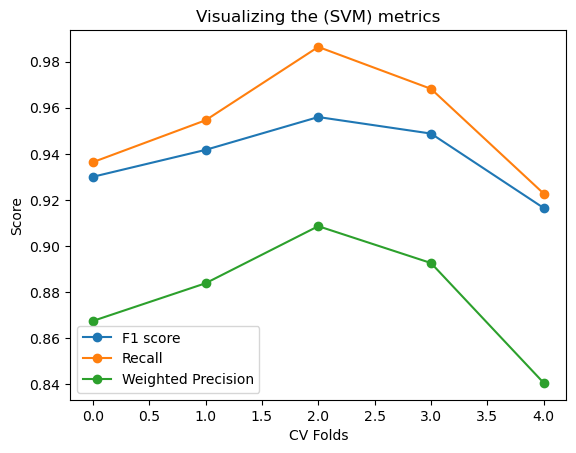

In [15]:
# Plot evaluation scores for each fold
visualize_metrics(svm_f1_scores, svm_recall_scores, svm_precision_scores, 'SVM')

#### Implementing CNN as my chosen neural network

In [14]:
# I chose CNN for this classification because specifically designed to work with image data and are capable of 
# capturing spatial information and extracting features from images through convolutional layers with higher accuracy

In [16]:
num_of_classes = 2 # positive and negative in the "target" np array

# Defining model architecture for the CNN
def cnn_model_func(no_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(resize_width, resize_height,3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(no_classes, activation='softmax'))
    return model

In [17]:
# Running the CNN five-fold cross-validation throgh the test/train model
folds = 0
for train_indx, test_indx in strat_kfold.split(originalrepo, new_target):
    # Split data into training and test sets
    surfaceX_train, surfaceX_test = originalrepo[train_indx], originalrepo[test_indx]
    surfaceY_train, surfaceY_test = new_target[train_indx], new_target[test_indx]
    
    # Convert labels to categorical one-hot encoding
    surfaceY_train_categ = np_utils.to_categorical(surfaceY_train, num_of_classes)
    surfaceY_test_categ = np_utils.to_categorical(surfaceY_test, num_of_classes)

    # Creating the CNN model for each fold
    cnn_model = cnn_model_func(num_of_classes)
    
    # Compiling the model
    cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    X_train_reshape = surfaceX_train.reshape(surfaceX_train.shape[0], resize_width, resize_height, 3)
    # Convert to float 32
    X_train_reshape = X_train_reshape.astype('float32')

    X_test_reshape = surfaceX_test.reshape(surfaceX_test.shape[0], resize_width, resize_height, 3)
    # Convert to float 32
    X_test_reshape = X_test_reshape.astype('float32')
    
    # normalise
    X_train_reshape /= 255 
    X_test_reshape /= 255
    
    # Fitting the CNN model on Training data
    cnn_model.fit(X_train_reshape, surfaceY_train_categ, epochs=5, batch_size=32, verbose=0) # verbose is set to 0 due to loops in 5-fold

    # Making predictions with the model on the test set
    cnn_y_predicted = cnn_model.predict(X_test_reshape)
    cnn_y_predicted = npy.argmax(cnn_y_predicted, axis=1)
    
    # Calculate F1 score, recall, and weighted precision
    cnn_f1_scores[folds] = f1_score(surfaceY_test, cnn_y_predicted)
    cnn_recall_scores[folds] = recall_score(surfaceY_test, cnn_y_predicted)
    cnn_precision_scores[folds] = precision_score(surfaceY_test, cnn_y_predicted, average='weighted')
    cnn_loss[folds], cnn_accuracy[folds] = cnn_model.evaluate(X_test_reshape, surfaceY_test_categ, verbose=0)
    
    BACK_END.clear_session() # free up memory space for models
    folds = folds + 1

print (surfaceX_train.shape, surfaceX_test.shape)
# To compute the average F1-score, Recall and weighted precision of the results
print("F1 score: {:.3f}".format(npy.mean(cnn_f1_scores)))
print("Recall: {:.3f}".format(npy.mean(cnn_recall_scores)))
print("Weighted Precision: {:.3f}".format(npy.mean(cnn_precision_scores)))
print("")
print("Loss: {:.3f}".format(npy.mean(cnn_loss)))
print("Accuracy: {:.3f}".format(npy.mean(cnn_accuracy)))

8/8 [==============================] - 1s 90ms/step


C:\Users\ditco\anaconda3\envs\v-env\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 92ms/step
(983, 100, 100, 3) (245, 100, 100, 3)
F1 score: 0.950
Recall: 0.997
Weighted Precision: 0.867

Loss: 0.241
Accuracy: 0.906


In [18]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 128)               9437312   
                                                        

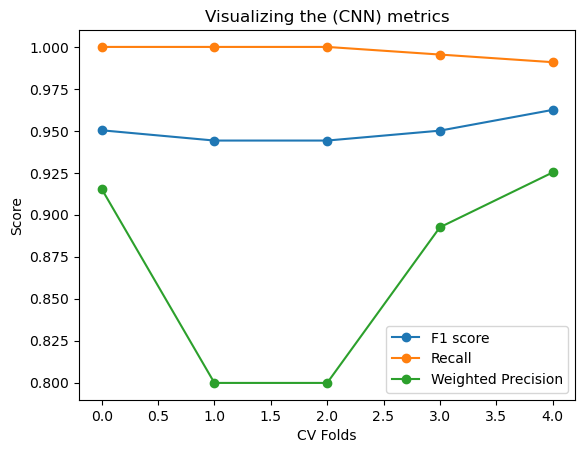

In [19]:
# Plot evaluation scores for each fold
visualize_metrics(cnn_f1_scores, cnn_recall_scores, cnn_precision_scores, 'CNN')

#### Task 1 Discussion
SVM Metrics: { F1-Score: 0.939, Recall: 0.954, Precision: 0.879 }

CNN Metrics: { F1 score: 0.950, Recall: 0.997, Precision: 0.867 }

From the metrics assessed, Both SVM and CNN used in this training have great balance between precision and recall, high proportion of true positives against false negatives and high precision across all classes.

However, the SVM model correctly predicted 88.8% of the total samples with an accuracy of 0.888 while the CNN performed better with an accuracy of 0.906 which implies that CNN model correctly predicted 90.6% of the total samples.

Therefore, CNN model is the best.

## Task 2

In [20]:
#Underwater image loading from source

resize_width = 100
resize_height = 100
path_to_underwater = 'dataset/Underwater'
images_u = [] # Storage to append the images as 2D numpy arrays.
target_u = [] # Storage to append the target
flattenedrepo_u = [] # Create a repo for flattened pixels

for root, dirs, files in os.walk(path_to_underwater):
     for file in files:
        with open(os.path.join(root, file), "r") as auto:
            try:
                img = cv2.imread(root+'/'+file)
                img = cv2.resize(img, (resize_width, resize_height)) 
                images_u.append(img)
                # Append the folder where the image is to the target list
                target_u.append(root.replace(path_to_underwater,'').replace('\\','').replace('/',''))
            except Exception as e:
                print("Invalid file "+file+" skipped.")
                
# Convert the original images list into numpy array
originalrepo_u = npy.array(images_u)
print(originalrepo_u)
print(npy.array(target_u))
print(""*2)
print('Number of negative Underwater images is:', len(os.listdir(path_to_underwater + '/Negative/'))) #length of negative training images
print('Number of postive Underwater images is:', len(os.listdir(path_to_underwater + '/Positive/'))) #length of positive training images 
print('Total training images is:', len(os.listdir(path_to_underwater+'/Negative/')) + len(os.listdir(path_to_underwater+'/Positive/')))

[[[[191 120 158]
   [207 124 160]
   [161  82  93]
   ...
   [134  50  28]
   [134  48  26]
   [135  66  61]]

  [[192 118 146]
   [213 136 170]
   [229 141 184]
   ...
   [132  49  27]
   [176 108 101]
   [159  61  42]]

  [[184 106 137]
   [184 109 130]
   [190 112 142]
   ...
   [128  48  25]
   [126  51  35]
   [128  48  24]]

  ...

  [[175  80  60]
   [181  91  69]
   [128  62  41]
   ...
   [  1   2   0]
   [  3   1   0]
   [  3   1   0]]

  [[149  85  63]
   [147  73  49]
   [137  67  48]
   ...
   [  3   1   0]
   [  3   1   0]
   [  3   1   0]]

  [[154  70  49]
   [144  72  50]
   [147  75  51]
   ...
   [  3   1   0]
   [  4   2   1]
   [  2   0   0]]]


 [[[ 13  15  12]
   [ 23  23  22]
   [ 20  20  21]
   ...
   [  4   5   3]
   [  2   3   1]
   [  3   4   2]]

  [[ 11  12  10]
   [ 12  13  11]
   [ 14  13  15]
   ...
   [  2   3   1]
   [  2   3   1]
   [  4   5   3]]

  [[ 10   8   7]
   [ 16  14  13]
   [ 18  17  19]
   ...
   [  2   3   1]
   [  3   4   2]
   [  2   3

In [21]:
# necessary to convert target values to numeric labels because string labels are not suitable for training
encoder = LabelEncoder()
new_target_u = encoder.fit_transform(target_u)
print(new_target_u, new_target_u.shape)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] (54,)


In [22]:
#Identifying the train and test dataset

surface_train_img = originalrepo
surface_train_labels = new_target

uwater_test_img = originalrepo_u
uwater_test_labels = new_target_u

In [23]:
print(surface_train_img.shape, surface_train_labels.shape, uwater_test_img.shape, uwater_test_labels.shape)

(1228, 100, 100, 3) (1228,) (54, 100, 100, 3) (54,)


In [24]:
#Reshaping train and test data into four dimensions.
X_train_reshape_u = surface_train_img.reshape(surface_train_img.shape[0], resize_width, resize_height, 3)
# Convert to float 32
X_train_reshape_u = X_train_reshape_u.astype('float32')

X_test_reshape_u = uwater_test_img.reshape(uwater_test_img.shape[0], resize_width, resize_height, 3)
# Convert to float 32
X_test_reshape_u = X_test_reshape_u.astype('float32')

#normalising
X_train_reshape_u /= 255 
X_test_reshape_u /= 255

In [25]:
# Convert labels to categorical one-hot encoding
SurfaceY_train_categ = np_utils.to_categorical(surface_train_labels, num_of_classes)
UnderwaterY_test_categ = np_utils.to_categorical(uwater_test_labels, num_of_classes)

In [26]:
# Creating the CNN model
cnn_model_uw = cnn_model_func(2)

# Compiling the model
cnn_model_uw.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Retraining the CNN model on Surface data
cnn_model_uw.fit(X_train_reshape_u, SurfaceY_train_categ, epochs=5, batch_size=32, verbose=1)

# Making predictions with the model on the test set
cnn_y_pred_uwater = cnn_model_uw.predict(X_test_reshape_u)
cnn_y_pred_uwater = npy.argmax(cnn_y_pred_uwater, axis=1)

# Calculate F1 score, recall, and weighted precision
cnn_f1_scores_u = f1_score(uwater_test_labels, cnn_y_pred_uwater)
cnn_recall_scores_u = recall_score(uwater_test_labels, cnn_y_pred_uwater)
cnn_precision_scores_u = precision_score(uwater_test_labels, cnn_y_pred_uwater, average='binary')
cnn_confmatrix_u = confusion_matrix(uwater_test_labels, cnn_y_pred_uwater)
cnn_loss_u, cnn_accuracy_u = cnn_model_uw.evaluate(X_test_reshape_u, UnderwaterY_test_categ, verbose=0)
roc_score = roc_auc_score(uwater_test_labels, cnn_y_pred_uwater)

# To compute the average F1-score, Recall and weighted precision of the results
print("")
print("F1 score: {:.3f}".format((cnn_f1_scores_u)))
print("Recall: {:.3f}".format((cnn_recall_scores_u)))
print("Precision: {:.3f}".format((cnn_precision_scores_u)))
print("ROC Score: {:.3f}".format((roc_score)))
print("Accuracy: {:.3f}".format((cnn_accuracy_u)))
print("")
print("Confusion matrix")
print(cnn_confmatrix_u)
#print("Loss: {:.3f}".format((cnn_loss_u)))


Epoch 1/5
39/39 [==============================] - 23s 576ms/step - loss: 0.6264 - accuracy: 0.8770
Epoch 2/5
39/39 [==============================] - 23s 578ms/step - loss: 0.2626 - accuracy: 0.8958
Epoch 3/5
39/39 [==============================] - 22s 571ms/step - loss: 0.2321 - accuracy: 0.8998
Epoch 4/5
39/39 [==============================] - 23s 598ms/step - loss: 0.2086 - accuracy: 0.9218
Epoch 5/5
2/2 [==============================] - 0s 60ms/step

F1 score: 0.632
Recall: 0.889
Precision: 0.490
ROC Score: 0.481
Accuracy: 0.481

Confusion matrix
[[ 2 25]
 [ 3 24]]


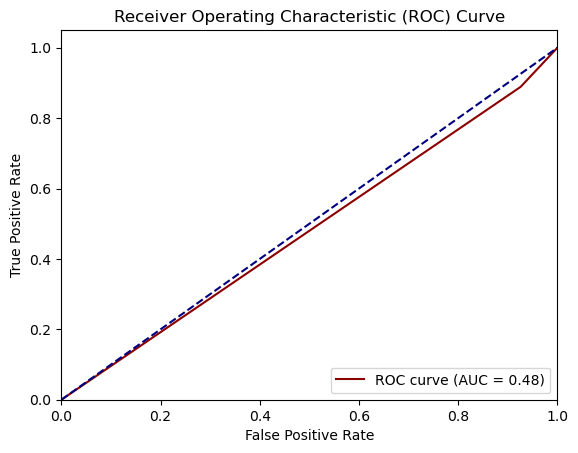

In [27]:
#ROC metric

# Calculatting TPR and FPR for different thresholds
fpr, tpr, thresholds = roc_curve(uwater_test_labels, cnn_y_pred_uwater)

# Calculating the AUC
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkred', label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### Task 2 Discussion
From the metrics, I observe that performance (or prediction) is not so good. The F1 score and recall are moderately fair at 63.2% and 88.9% respectively; this indicates that the model is somewhat effective in identifying positive samples. With a low precision, it means that the model has a relatively high proportion of false positives.

The ROC score and accuracy are also not impressive, the classifier’s performance is not much better with respect to the samples, this does not mean CNN is weak to accurately predict but I suspect this might be as a result of imbalance or noisy data. The ROC Curve also reflects this with its overlapping lines.

In conclusion, the image samples probably needs some optimizations and preprocessing which shall be handled in Task 4.

## Task 3

In [28]:
#Loading non-corroded image  from source
noncorroded = path_to_surface + '/negative/'
resize_width = 100
resize_height = 100
images = [] # Storage to append the images as 2D numpy arrays.
target = [] # Storage to append the target

for root, dirs, files in os.walk(noncorroded):
     for file in files:
        with open(os.path.join(root, file), "r") as auto:
            try:
                img = cv2.imread(root+'/'+file)
                img = cv2.resize(img, (resize_width, resize_height)) 
                images.append(img)
                target.append(root.replace(path_to_surface,'').replace('\\','').replace('/',''))
            except Exception as e:
                print("Invalid file "+file+" skipped.")
                
# Convert the original images list into numpy array
noncorroded_repo = npy.array(images)
noncorroded_imgs = images
print(npy.array(target))
print(""*2)
#print('Number of negative Surface images is:', len(os.listdir(path + '/Negative/'))) #length of negative training images
print(noncorroded_repo.shape)

['negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negat

In [29]:
#Building instance of the Image Data Generator class

datagen = ImageDataGenerator(
    #rescale=1./255,
    rotation_range = 45,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.25,
    zoom_range = 0.25,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'reflect',
    validation_split=0
    )

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

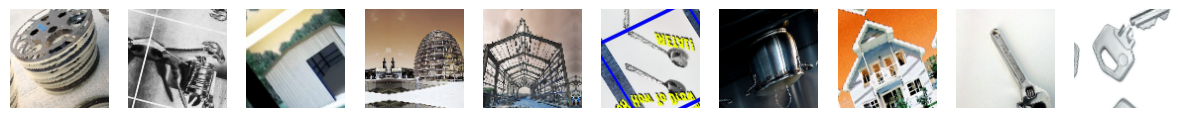

In [30]:
#Scanning through the surface/negative (non-corroded) image to prepare augmented versions
loop = 0
augmented_imgs = []
augmented_imgs_target = []
augmented_path = path_to_surface + '/negative'
#for batch in datagen.flow(noncorroded_repo,
aug_datagen = datagen.flow(noncorroded_repo,
                            batch_size = 16,
                            seed = 2023, #for reproducible seed
                            save_to_dir = augmented_path, 
                            save_prefix = 'aug'
                            )
for batch in aug_datagen:
    augmented_imgs.append((batch))
    loop += 1
    if loop > 50:
        break

#--->>Augmented images are stored into "dataset/augmented_surface" directory

augmented_repo1 = npy.array(augmented_imgs) #Augmented images stored in numy array on the fly

fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(15,15))

for i in range(10):

#  # convert to unsigned integers for plotting
  image = next(aug_datagen)[0].astype('uint8')

#  # changing size for plotting the image
  image = npy.squeeze(image)

#  # plot raw pixel data
  ax[i].imshow(image)
  ax[i].axis('off')

In [31]:
#Number of images after augmentation

print('Number of negative (non-corroded) surface samples after augmentation is:', len(os.listdir(path_to_surface + '/Negative/'))) 
print('Number of postive (corroded) surface samples is:', len(os.listdir(path_to_surface + '/Positive/'))) 
print('Total training images is:', len(os.listdir(path_to_surface+'/Negative/')) + len(os.listdir(path_to_surface+'/Positive/')))

Number of negative (non-corroded) surface samples after augmentation is: 1104
Number of postive (corroded) surface samples is: 1104
Total training images is: 2208


In [32]:
#Preparing the Train Data
train_generator = datagen.flow_from_directory(path_to_surface,
                                            batch_size = 32,
                                            target_size = (resize_width, resize_height),
                                            class_mode='binary',
                                            subset = 'training'
                                            )

Found 2208 images belonging to 2 classes.


In [33]:
#preparing the Test Data
test_generator = test_datagen.flow_from_directory(
        path_to_underwater,
        target_size=(resize_width, resize_height),
        batch_size=32,
        class_mode='binary')

Found 54 images belonging to 2 classes.


In [34]:
print("Training set samples:",train_generator.samples)
print("Test set samples:",test_generator.samples)

Training set samples: 2208
Test set samples: 54


In [55]:
#Reload the augmsented image
aug_img_surface = loadimage(path_to_surface)
aug_labels = loadimage(path_to_surface, 'yes')
#Identifying the train and test dataset
aug_surface_train = npy.array(aug_img_surface)
aug_surface_train_labels = npy.array(aug_labels)

uwater_test_img = originalrepo_u
uwater_test_labels = new_target_u

aug_surface_train_labels = encoder.fit_transform(aug_surface_train_labels)

Invalid file rusted_airplane_53.jpg skipped.
Invalid file rusted_car_72.jpg skipped.
Invalid file rusted_objects_398.jpg skipped.
Invalid file rusted_objects_40.jpg skipped.


In [65]:
print(aug_surface_train.shape, aug_surface_train_labels.shape, uwater_test_img.shape, uwater_test_labels.shape)

(2204, 100, 100, 3) (2204,) (54, 100, 100, 3) (54,)


In [66]:
#Reshaping train and test data into four dimensions.
augX_train_reshape = aug_surface_train.reshape(aug_surface_train.shape[0], resize_width, resize_height, 3)
# Convert to float 32
augX_train_reshape = augX_train_reshape.astype('float32')

augX_test_reshape = uwater_test_img.reshape(uwater_test_img.shape[0], resize_width, resize_height, 3)
# Convert to float 32
augX_test_reshape = augX_test_reshape.astype('float32')

#normalising
augX_train_reshape /= 255 
augX_test_reshape /= 255

# Convert labels to categorical one-hot encoding
augSurfaceY_train_categ = np_utils.to_categorical(aug_surface_train_labels, num_of_classes)
augUnderwaterY_test_categ = np_utils.to_categorical(uwater_test_labels, num_of_classes)

In [68]:
xymodel = cnn_model_func(2)
# Compile the model
xymodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

xymodel.fit(augX_train_reshape, augSurfaceY_train_categ, epochs=5, batch_size=32, verbose=1)

Epoch 1/5
69/69 [==============================] - 38s 532ms/step - loss: 0.6727 - accuracy: 0.6897
Epoch 2/5
69/69 [==============================] - 36s 526ms/step - loss: 0.3552 - accuracy: 0.8575
Epoch 3/5
69/69 [==============================] - 37s 532ms/step - loss: 0.2717 - accuracy: 0.9047
Epoch 4/5
69/69 [==============================] - 37s 530ms/step - loss: 0.2343 - accuracy: 0.9156
Epoch 5/5
69/69 [==============================] - 38s 555ms/step - loss: 0.1895 - accuracy: 0.9297


In [69]:
xymodel.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 conv2d_15 (Conv2D)          (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 48, 48, 32)        0         
                                                                 
 flatten_5 (Flatten)         (None, 73728)             0         
                                                                 
 dense_10 (Dense)            (None, 128)               9437312   
                                                      

In [705]:
print(len(train_generator.classes))

2208


In [70]:
# Making predictions with the model on the test set
aug_pred_uwater = xymodel.predict(augX_test_reshape)
aug_pred_uwater = npy.argmax(aug_pred_uwater, axis=1)

# Calculate F1 score, recall, and weighted precision
aug_f1_scores_u = f1_score(uwater_test_labels, aug_pred_uwater)
aug_recall_scores_u = recall_score(uwater_test_labels, aug_pred_uwater)
aug_precision_scores_u = precision_score(uwater_test_labels, aug_pred_uwater, average='binary')
aug_confmatrix_u = confusion_matrix(uwater_test_labels, aug_pred_uwater)
aug_loss_u, aug_accuracy_u = xymodel.evaluate(augX_test_reshape, augUnderwaterY_test_categ, verbose=0)
roc_score = roc_auc_score(uwater_test_labels, aug_pred_uwater)

# To compute the average F1-score, Recall and weighted precision of the results
print("")
print("F1 score: {:.3f}".format((aug_f1_scores_u)))
print("Recall: {:.3f}".format((aug_recall_scores_u)))
print("Precision: {:.3f}".format((aug_precision_scores_u)))
print("ROC Score: {:.3f}".format((roc_score)))
print("Accuracy: {:.3f}".format((aug_accuracy_u)))
print("")
print("Confusion matrix")
print(aug_confmatrix_u)

2/2 [==============================] - 0s 57ms/step

F1 score: 0.457
Recall: 0.296
Precision: 1.000
ROC Score: 0.648
Accuracy: 0.648

Confusion matrix
[[27  0]
 [19  8]]


0.6481481481481481


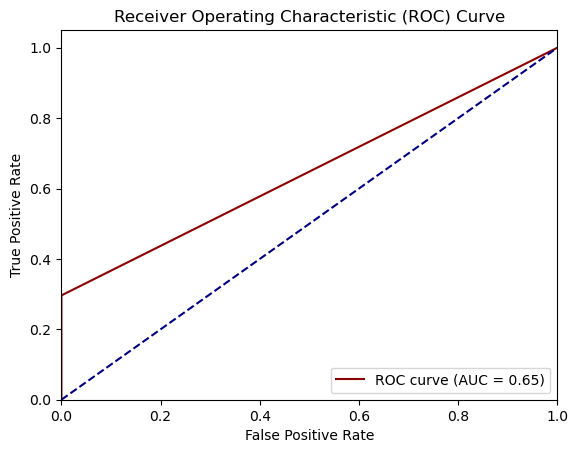

In [71]:
#ROC metric

# Calculatting TPR and FPR for different thresholds
fpr, tpr, thresholds = roc_curve(uwater_test_labels, aug_pred_uwater)

# Calculating the AUC
auc_score = auc(fpr, tpr)
print(auc_score)
plt.plot(fpr, tpr, color='darkred', label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### Task 3 Discussion
From the metrics, I observe that performance (or prediction) is fairly better than in Task 2. The F1 score and recall are moderately fair at 45.7% and 29.6% respectively.

This resulted in precision value of 1, I suspect overfitting of some sort. However this experiment yielded an accuracy of 0.648 (64.8%) when trained with larger dataset after augmentation, this accuracy is better than 48.1% accuracy gotten when trained with lesser dataset in Task 2. The confusion matrix also has more accurate prediction than in tax 2.

In conclusion, I can say there's slight difference in the result from the analysis.

## Task 4

In [ ]:
#Trim, Invert, Transpose, Colour contrast, Normalize, Denoise, Segment

In [73]:
#Loading the negative 
negative_uwater = loadimage(path_to_underwater+'/negative/')
positive_uwater = loadimage(path_to_underwater+'/positive/')
all_uwater = loadimage(path_to_underwater)

negative_uwater = npy.array(negative_uwater)
positive_uwater = npy.array(positive_uwater)
all_uwater = npy.array(all_uwater)

Invalid file Corrosion-2.gif skipped.
Invalid file Corrosion-2.gif skipped.


In [76]:
negative_uwater = npy.array(negative_uwater)
positive_uwater = npy.array(positive_uwater)
all_uwater = npy.array(all_uwater)

print(negative_uwater.shape)
print(positive_uwater.shape)
print(all_uwater.shape)

(60, 100, 100, 3)
(59, 100, 100, 3)
(119, 100, 100, 3)


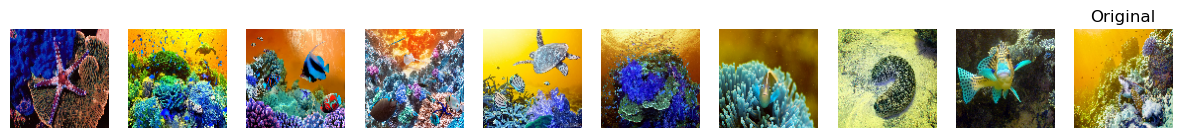

In [77]:
#Negative
display_n_image(10,negative_uwater)

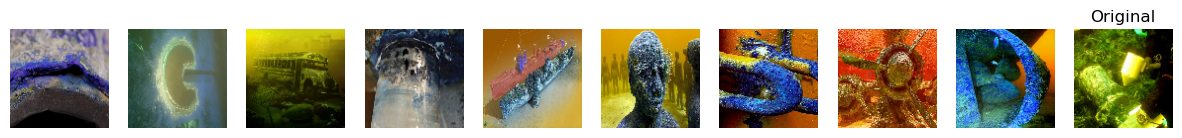

In [78]:
#Positive
display_n_image(10,positive_uwater)

In [79]:
#Annotating the images
def annotate_image(image_np_array):
    image_array = npy.array(image_np_array)
    #image_array = (image_np_array)
    annotated_img = []
    for i in range(image_array.shape[0]):
        image = Image.fromarray(image_array[i])

        # Create a drawing object
        draw = ImageDraw.Draw(image)

        # Define the bounding box coordinates
        bbox = (10, 10, 70, 70)

        # Draw the bounding box on the image
        draw.rectangle(bbox, outline='red')
        #annotated_img[i] = npy.array(image)
        annotated_img.append(npy.array(image))
    return annotated_img
#print(annotated_img[0])

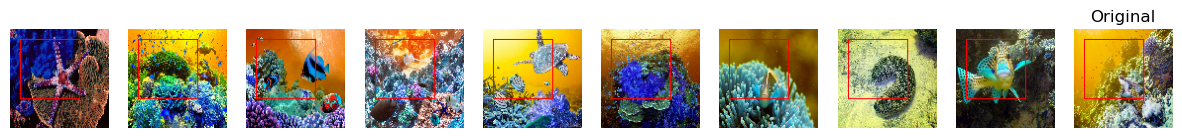

In [80]:
annotated_img_neg = annotate_image(negative_uwater)
display_n_image(10,annotated_img_neg)

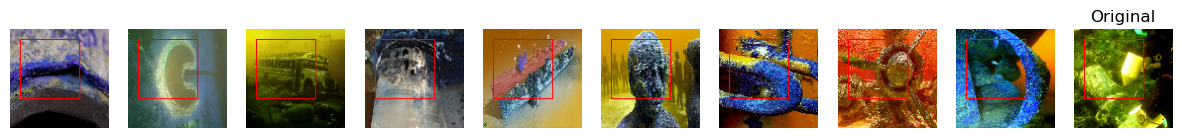

In [81]:
annotated_img_pos = annotate_image(positive_uwater)
display_n_image(10,annotated_img_pos)

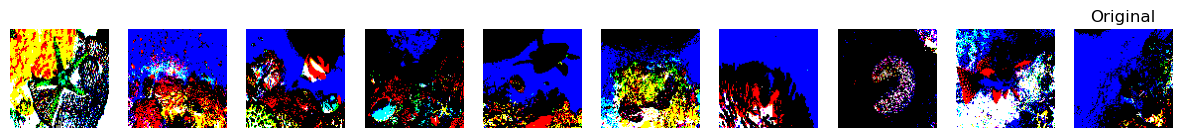

In [82]:
#Trim, Invert, Transpose, Colour contrast, Normalize, Denoise, Segment
def grey_image(image_np_array):
    binarized_img = []
    image_array = npy.array(image_np_array)
    for i in range(image_array.shape[0]):
        image = Image.fromarray(image_array[i])
        # binarising the image
        image = npy.array(image)
        image[0,0]=0
        #_,image = cv2.threshold(image,220,255,cv2.THRESH_BINARY)
        binarized_img.append(image)
    return binarized_img 

def invert_image(image_np_array):
    inverted_img = []
    image_array = npy.array(image_np_array)
    for i in range(image_array.shape[0]):
        image = Image.fromarray(image_array[i])
        # inverting the image
        image = 255 - npy.array(image)
        inverted_img.append(image)
    return inverted_img 

def binarize_image(image_np_array):
    binarized_img = []
    image_array = npy.array(image_np_array)
    for i in range(image_array.shape[0]):
        image = Image.fromarray(image_array[i])
        # binarising the image
        image = npy.array(image)
        _,image = cv2.threshold(image,200,255,cv2.THRESH_BINARY)
        binarized_img.append(image)
    return binarized_img 

def rebinarize_image(image_np_array):
    binarized_img = []
    image_array = npy.array(image_np_array)
    for i in range(image_array.shape[0]):
        image = Image.fromarray(image_array[i])
        # binarising the image
        image = npy.array(image)
        image = binarise(image, 215)
        binarized_img.append(image)
    return binarized_img 

def binarise(img, threshold):
    '''This function biniarises an image in a numpy array according to the specified threshold'''
    img_bin = img.copy()
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if img[x,y]<threshold:
                img_bin[x,y]=0
            else:
                img_bin[x,y]=255
    #plt.imshow(img_bin, cmap='Greys_r')
    return img_bin

def preprocessing(image_np_array):
    #invert image
    processed_img = []
    image_array = npy.array(image_np_array)
    for i in range(image_array.shape[0]):
        image = Image.fromarray(image_array[i])
                
        # inverting the image
        image = 255 - npy.array(image)
        
        # Convert image to grayscale
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # add blur filter to the image
        #image = cv2.GaussianBlur(image, (5, 5), 0)
        
        # add edge detection filter to the image
        #image = cv2.Canny(image, 100, 200)
        
        #Trimming the image
        #Transposing the image
        #image = image.transpose()
        
        #Normalize
        #image = image/255
        
        _,image = cv2.threshold(image,220,255,cv2.THRESH_BINARY)
        #plt.imshow(thresh1, cmap='Greys_r')

        #Annotate the image
        #image = annotate_image(image)

        processed_img.append(image)
        
    return processed_img

#annotated_img_neg = annotate_image(negative_uwater)
preprocessed = preprocessing(negative_uwater)
display_n_image(10,preprocessed)
#preprocessing(negative_uwater)

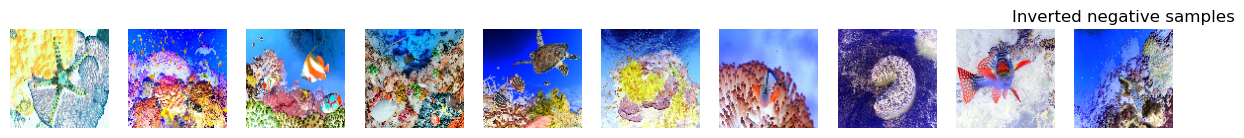

In [83]:
#Negative
inverted_img = invert_image(negative_uwater)
display_n_image(10,inverted_img, "Inverted negative samples")

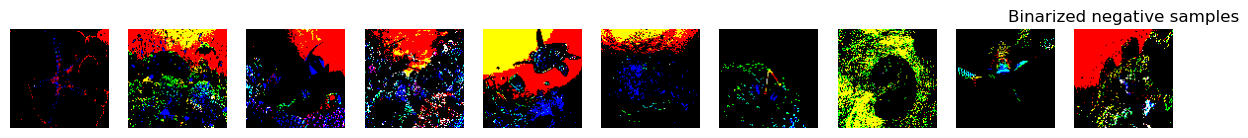

In [379]:
#Negative
binarized_img = binarize_image(negative_uwater)
display_n_image(10,binarized_img, "Binarized negative samples")

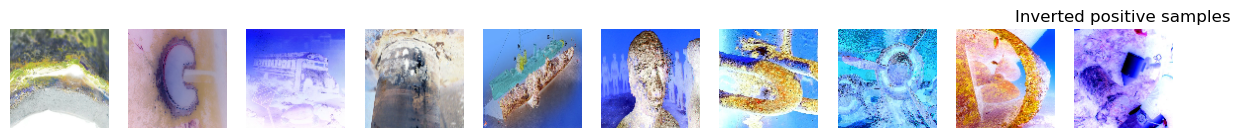

In [84]:
#Positive
inverted_img = invert_image(positive_uwater)
display_n_image(10,inverted_img, "Inverted positive samples")

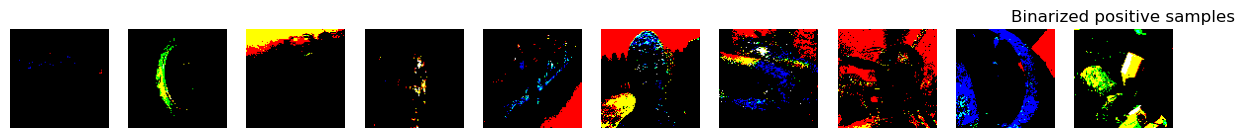

In [85]:
#Positive
binarized_img = binarize_image(positive_uwater)
display_n_image(10,binarized_img, "Binarized positive samples")

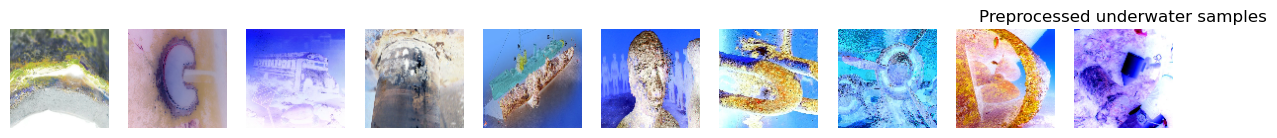

In [88]:
#Applying preprocessing to all images
prep_img = invert_image(binarize_image(invert_image(grey_image(all_uwater))))
display_n_image(10,inverted_img, "Preprocessed underwater samples")

In [90]:
print(npy.array(prep_img).shape)

(119, 100, 100, 3)


In [94]:
#Reload the augmsented image
Paug_img_surface = aug_img_surface
Paug_labels = aug_labels
#Identifying the train and test dataset
Paug_surface_train = npy.array(Paug_img_surface)
Paug_surface_train_labels = npy.array(Paug_labels)

uwater_test_img = npy.array(prep_img)
uwater_test_labels = npy.array(loadimage(path_to_underwater, 'yes'))
uwater_test_labels = encoder.fit_transform(uwater_test_labels)

Paug_surface_train_labels = encoder.fit_transform(Paug_surface_train_labels)

print(Paug_surface_train.shape, Paug_surface_train_labels.shape, uwater_test_img.shape, uwater_test_labels.shape)

#Reshaping train and test data into four dimensions.
PaugX_train_reshape = Paug_surface_train.reshape(Paug_surface_train.shape[0], resize_width, resize_height, 3)
# Convert to float 32
PaugX_train_reshape = PaugX_train_reshape.astype('float32')

PaugX_test_reshape = uwater_test_img.reshape(uwater_test_img.shape[0], resize_width, resize_height, 3)
# Convert to float 32
PaugX_test_reshape = PaugX_test_reshape.astype('float32')

#normalising
PaugX_train_reshape /= 255 
PaugX_test_reshape /= 255

# Convert labels to categorical one-hot encoding
augSurfaceY_train_categ = np_utils.to_categorical(Paug_surface_train_labels, num_of_classes)
augUnderwaterY_test_categ = np_utils.to_categorical(uwater_test_labels, num_of_classes)

Pxymodel = cnn_model_func(2)
# Compile the model
Pxymodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Pxymodel.fit(PaugX_train_reshape, augSurfaceY_train_categ, epochs=2, batch_size=32, verbose=1)

(2204, 100, 100, 3) (2204,) (119, 100, 100, 3) (119,)
Epoch 1/2
69/69 [==============================] - 40s 560ms/step - loss: 0.5947 - accuracy: 0.7609
Epoch 2/2
69/69 [==============================] - 38s 557ms/step - loss: 0.3479 - accuracy: 0.8702


In [95]:
# Making predictions with the model on the test set
Paug_pred_uwater = Pxymodel.predict(PaugX_test_reshape)
Paug_pred_uwater = npy.argmax(Paug_pred_uwater, axis=1)

# Calculate F1 score, recall, and weighted precision
Paug_f1_scores_u = f1_score(uwater_test_labels, Paug_pred_uwater)
Paug_recall_scores_u = recall_score(uwater_test_labels, Paug_pred_uwater)
Paug_precision_scores_u = precision_score(uwater_test_labels, Paug_pred_uwater, average='binary')
Paug_confmatrix_u = confusion_matrix(uwater_test_labels, Paug_pred_uwater)
Paug_loss_u, Paug_accuracy_u = Pxymodel.evaluate(PaugX_test_reshape, augUnderwaterY_test_categ, verbose=0)
roc_score = roc_auc_score(uwater_test_labels, Paug_pred_uwater)

# To compute the average F1-score, Recall and weighted precision of the results
print("")
print("F1 score: {:.3f}".format((Paug_f1_scores_u)))
print("Recall: {:.3f}".format((Paug_recall_scores_u)))
print("Precision: {:.3f}".format((Paug_precision_scores_u)))
print("ROC Score: {:.3f}".format((roc_score)))
print("Accuracy: {:.3f}".format((Paug_accuracy_u)))
print("")
print("Confusion matrix")
print(Paug_confmatrix_u)

4/4 [==============================] - 0s 64ms/step

F1 score: 0.492
Recall: 0.492
Precision: 0.492
ROC Score: 0.496
Accuracy: 0.496

Confusion matrix
[[30 30]
 [30 29]]


#### Task 4 Discussion
In this part, I added more images to the underwater dataset to make 60 positive and 60 negative images.

In this part, I intend to apply a test on the preprocessed underwater samples, using the augmented surface.

### References

https://datagen.tech/guides/image-annotation/image-annotation/

https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/

https://rgu-repository.worktribe.com/output/1369876/image-pre-processing-and-segmentation-for-real-time-subsea-corrosion-inspection
